In [1]:
# Libraries

import pandas as pd
import time
import numpy as np
import random
import os
from tqdm import tqdm

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.vgg16 import VGG16

%matplotlib inline

## Preprocessing

In [2]:
train_dir = 'D:/documents/GitHub/Radios_COVID19/COVID-19_Radiography_Dataset'

normal_imgs = [fn for fn in os.listdir(f'{train_dir}/Normal/images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{train_dir}/COVID/images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{train_dir}/Viral Pneumonia/images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{train_dir}/Lung_Opacity/images') if fn.endswith('.png')]

In [3]:
#Randomly select X of each images
random_sample = 400

select_norm = np.random.choice(normal_imgs, random_sample, replace = False)
select_covid = np.random.choice(covid_imgs, random_sample, replace = False)
select_pneumonia = np.random.choice(pneumonia_imgs, random_sample, replace = False)
select_lung_opacity = np.random.choice(lung_opacity_imgs, random_sample, replace = False)

In [4]:
liste = []

for fn in select_norm :
    liste.append(f'{train_dir}/Normal/images/' + fn)
for fn in select_covid :
    liste.append(f'{train_dir}/COVID/images/' + fn)
for fn in select_pneumonia :
    liste.append(f'{train_dir}/Viral Pneumonia/images/' + fn)
for fn in select_lung_opacity :
    liste.append(f'{train_dir}/Lung_Opacity/images/' + fn)

liste = list(map(lambda x : [x, x.split('/')[5]], liste))

In [5]:
#Créer un DataFrame pandas
df = pd.DataFrame(liste, columns = ['filepath', 'nameLabel'])
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))]).astype(str)

print('DataFrame size : ', df.shape)
print(df['nameLabel'].value_counts())
df.head()

DataFrame size :  (1600, 3)
Normal             400
COVID              400
Viral Pneumonia    400
Lung_Opacity       400
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
1,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
2,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
3,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
4,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0


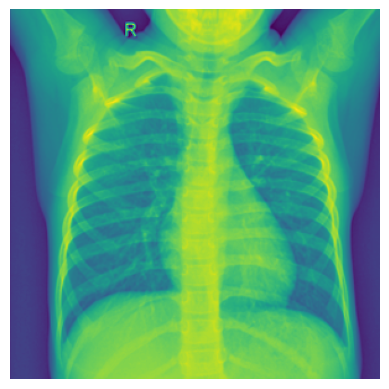

In [6]:
#Charger Exemple Image
filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

In [18]:
size = 224 #Image size (depending on model definition)
ratio_val = 0.2 #percentage of dataset to be held into test
batch_generator = 32

train_data_generator = ImageDataGenerator( )
test_data_generator = ImageDataGenerator( )

# Création des itérateurs qui chargeront des lots d'images
train, test = train_test_split(df, test_size = ratio_val, shuffle = False)

print(f"Number of rows in train set: {len(train)}")

train_generator = train_data_generator.flow_from_dataframe(dataframe = train,
                                                           x_col="filepath",
                                                           y_col="label",
                                                           class_mode = "sparse",
                                                           target_size = (size,size),
                                                           batch_size = batch_generator)

print(f"Number of rows in test set: {len(test)}")
test_generator = test_data_generator.flow_from_dataframe(dataframe = test,
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = (size,size),
                                                         batch_size = batch_generator,
                                                         shuffle=False) 


Number of rows in train set: 1280
Found 1280 validated image filenames belonging to 4 classes.
Number of rows in test set: 320
Found 320 validated image filenames belonging to 1 classes.


## VGG16 Model

In [19]:
#Chargement et freeze modèle de base
vgg16 = VGG16(weights=None, include_top = False)

for layer in vgg16.layers :
    layer.trainable = False

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [20]:
# Partie Classification

model = Sequential()
model.add(vgg16)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                      

In [21]:
# Compilation
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

## Entrainement Modèle

In [23]:
# Entrainement du modèle
train_size = train_generator.samples
test_size = test_generator.samples

batch_model = 32
epochs = 10

history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_size // batch_model,
                    validation_data = test_generator,
                    validation_steps = test_size // batch_model)

Epoch 1/10
40/40 [==============================] - 224s 6s/step - loss: 1.2720 - accuracy: 0.3250 - val_loss: 1.3809 - val_accuracy: 0.0000e+00
Epoch 2/10
40/40 [==============================] - 213s 5s/step - loss: 1.2577 - accuracy: 0.3602 - val_loss: 1.0818 - val_accuracy: 1.0000
Epoch 3/10
40/40 [==============================] - 221s 6s/step - loss: 1.2463 - accuracy: 0.3445 - val_loss: 1.2488 - val_accuracy: 0.0000e+00
Epoch 4/10
40/40 [==============================] - 217s 5s/step - loss: 1.2216 - accuracy: 0.3984 - val_loss: 1.1727 - val_accuracy: 0.1906
Epoch 5/10
40/40 [==============================] - 217s 5s/step - loss: 1.1602 - accuracy: 0.4680 - val_loss: 0.9015 - val_accuracy: 0.9375
Epoch 6/10
40/40 [==============================] - 220s 6s/step - loss: 1.0955 - accuracy: 0.4930 - val_loss: 1.3926 - val_accuracy: 0.2313
Epoch 7/10
40/40 [==============================] - 218s 5s/step - loss: 1.0208 - accuracy: 0.5477 - val_loss: 1.1497 - val_accuracy: 0.1281
Epoch

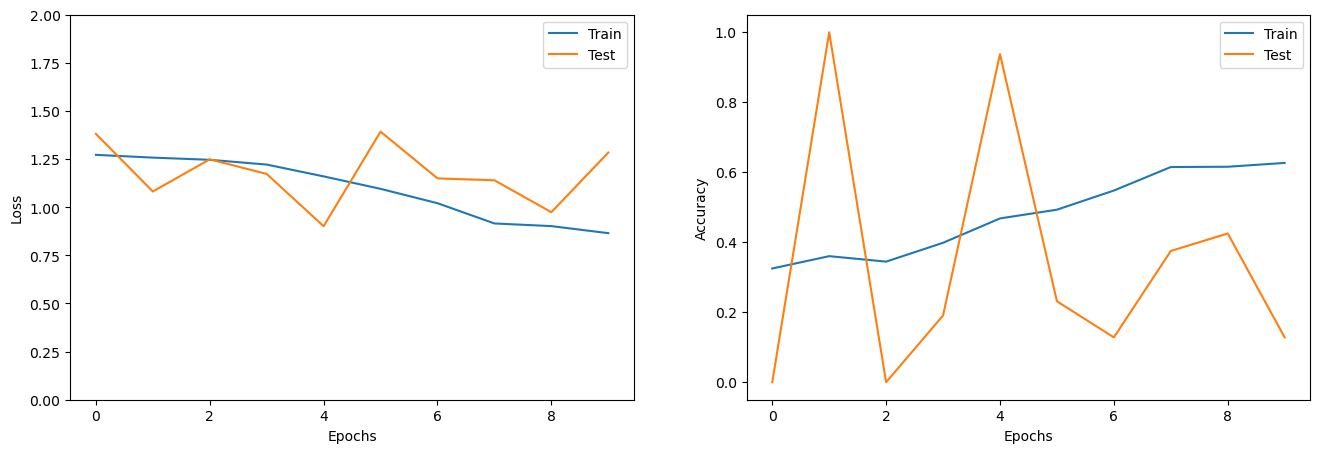

In [24]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

plt.subplot(121)
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

## Model Performance 

In [25]:
# Prédictions (probabilités)
test_generator.reset()
test_pred_lenet = model.predict(test_generator, verbose = 1 )

10/10 [==============================] - 40s 4s/step


In [26]:
# Récupération des classes à partir des probabilités
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)

# Matrice de confusion
print(confusion_matrix(test_generator.classes, test_pred_lenet_class))

[[ 41 229  50]
 [  0   0   0]
 [  0   0   0]]


In [27]:
print(classification_report(test_generator.classes, test_pred_lenet_class, target_names=test_generator.class_indices.keys()))

ValueError: Number of classes, 3, does not match size of target_names, 1. Try specifying the labels parameter